<a href="https://colab.research.google.com/github/gmfv/Prediccion_Temperatura_IA/blob/main/RedRecurrente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as split

from keras.layers import LSTM, Input, Dense
from keras.models import Model

#from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
#from bitstring import BitArray
from sklearn.preprocessing import MinMaxScaler

np.random.seed(1120)

In [49]:
def prepare_dataset(data, window_size):
    X, Y = np.empty((0,window_size)), np.empty((0))
    for i in range(len(data)-window_size-1):
        X = np.vstack([X,data[i:(i + window_size),0]])
        Y = np.append(Y,data[i + window_size,0])   
    X = np.reshape(X,(len(X),window_size,1))
    Y = np.reshape(Y,(len(Y),1))
    return X, Y

In [44]:
df = pd.read_csv('https://raw.githubusercontent.com/gmfv/Prediccion_Temperatura_IA/main/temperatura.csv')

pred = 2 #Por ser 24 horas del dia
#df = load_dataset('https://raw.githubusercontent.com/gmfv/Prediccion_Temperatura_IA/main/temperatura.csv')
df["Dia"]=df['date'].apply(lambda x: int(x.split()[0].split('-')[2]))
df["Mes"]=df['date'].apply(lambda x: int(x.split()[0].split('-')[1]))
df["Año"]=df['date'].apply(lambda x: int(x.split()[0].split('-')[0]))
df["Hora"]=df['date'].apply(lambda x: int(x.split()[1].split(':')[0]))
df["temp_t1"] = df["Temperatura Asuncion"].shift(periods=-pred)
df["Year_t1"] = df["Año"].shift(periods=-pred)
df["Hour_t1"] = df["Hora"].shift(periods=-pred)
df["Month_t1"] = df["Mes"].shift(periods=-pred)
df["Weekday_t1"] = df["Dia"].shift(periods=-pred)
df = df.dropna()
#df.drop(columns='date',inplace=True)
df=df.set_index("date")
df=df[df['Hora']%2 == 0]
#data["Temperatura Asuncion"]

In [54]:
data1

array([26.76923077, 24.21538462, 23.00769231, ..., 32.9       ,
       34.        , 35.1       ])

In [55]:
data1 = df["Temperatura Asuncion"].values
scaler = MinMaxScaler(feature_range=(0, 1))
data1 = scaler.fit_transform(np.reshape(data1, [-1,1]))
#data2 = scaler.fit_transform(data2)

In [56]:
df["Temperatura Asuncion"]=data1
#df["temp_t1"]=data2

In [57]:
train_data = df[['Temperatura Asuncion']].values[0:round(len(df)*0.8)]
test_data = df[['Temperatura Asuncion']].values[round(len(df)*0.8)+1:-1]

In [58]:
best_window_size=60
best_num_units=9

In [59]:
X_train,y_train = prepare_dataset(train_data,best_window_size)
X_test, y_test = prepare_dataset(test_data,best_window_size)

inputs = Input(shape=(best_window_size,1))
x = LSTM(best_num_units, input_shape=(best_window_size,1))(inputs)
predictions = Dense(1, activation='linear')(x)
model = Model(inputs = inputs, outputs = predictions)
model.compile(optimizer='adam',loss='mean_squared_error')
history=model.fit(X_train, y_train, epochs=35, batch_size=24, validation_data=(X_test, y_test), shuffle=True)
y_pred = model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: ', rmse)

Epoch 1/35
1310/1310 [==============================] - 20s 14ms/step - loss: 0.0101 - val_loss: 0.0023
Epoch 2/35
1310/1310 [==============================] - 18s 14ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 3/35
1310/1310 [==============================] - 18s 14ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 4/35
1310/1310 [==============================] - 18s 14ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 5/35
1310/1310 [==============================] - 18s 14ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/35
1310/1310 [==============================] - 18s 14ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 7/35
1310/1310 [==============================] - 18s 14ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 8/35
1310/1310 [==============================] - 18s 14ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 9/35
1310/1310 [==============================] - 18s 14ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 10/35
1310/1310 [==============================] - 18s 14m

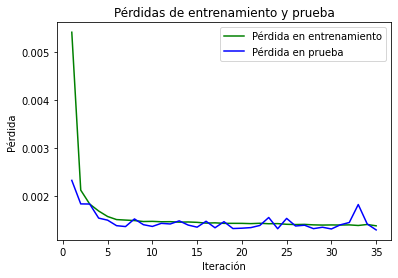

In [60]:
import matplotlib.pyplot as plt
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,36)
plt.plot(epochs, loss_train, 'g', label='Pérdida en entrenamiento')
plt.plot(epochs, loss_val, 'b', label='Pérdida en prueba')
plt.title('Pérdidas de entrenamiento y prueba')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [62]:
y_test

array([[23.2       ],
       [22.8388343 ],
       [24.12693318],
       ...,
       [29.9       ],
       [31.5       ],
       [32.9       ]])


Máxima diferencia:  [12.40493088] , Media:  0.1187065670037539


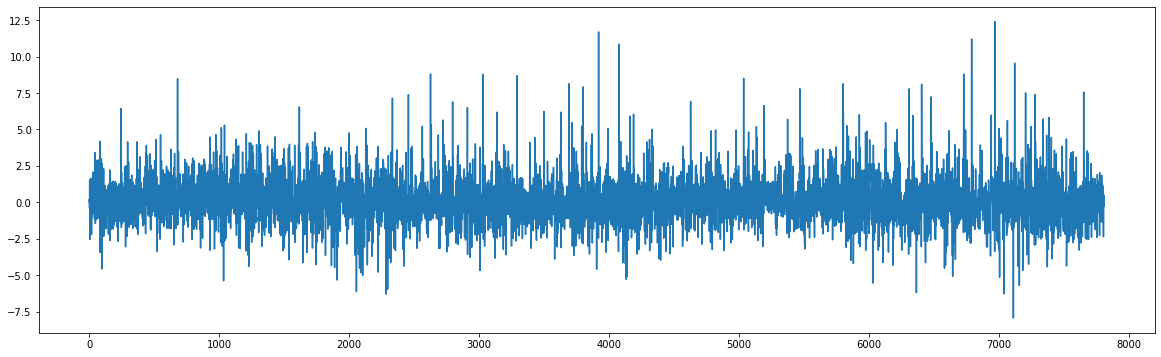

In [63]:
plt.figure(figsize= (20,6))
plt.plot(linewidth=0.2)
gradosdif=y_pred-y_test
plt.plot(gradosdif)
print('\nMáxima diferencia: ', max(np.abs(gradosdif)), ', Media: ', np.mean(gradosdif))

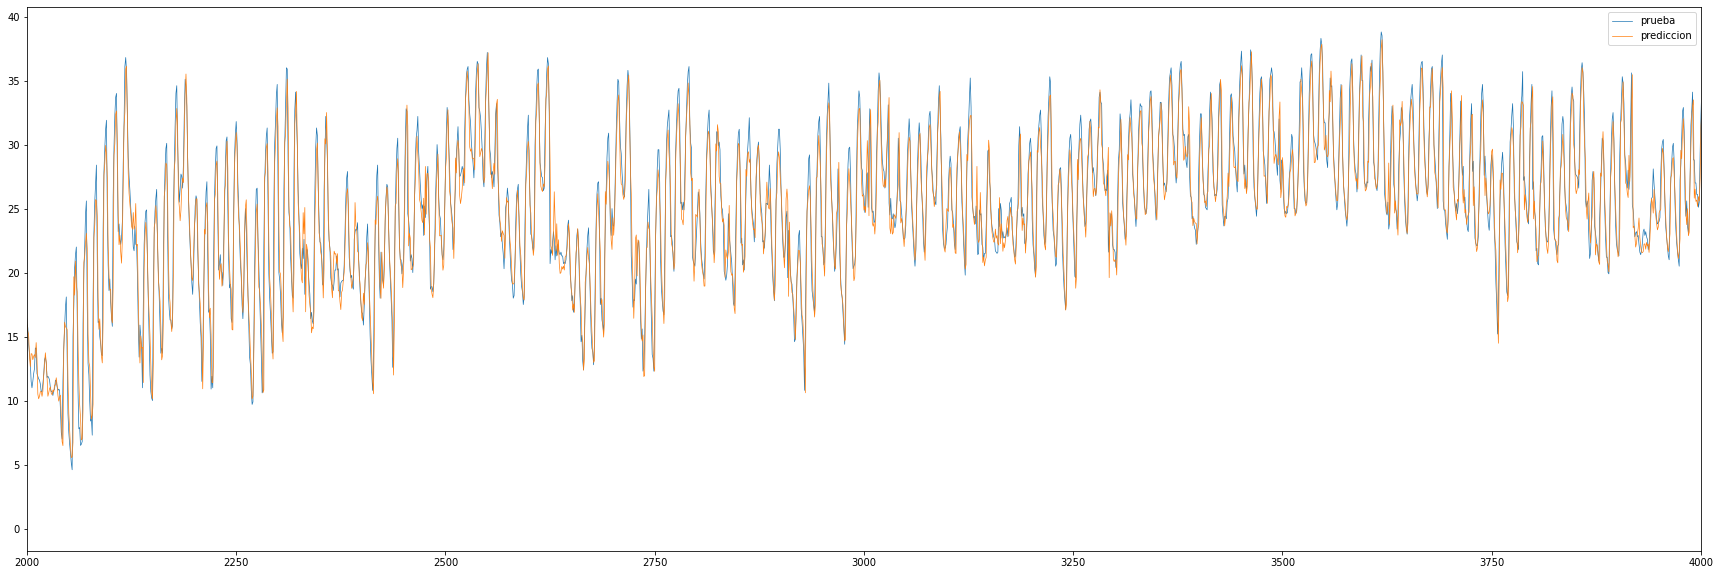

In [15]:
grafico=pd.DataFrame()
grafico['prueba']= y_test.reshape(len(y_test))
grafico['prediccion']= y_pred
grafico.plot(linewidth=0.7).set_xlim([2000, 4000])
plt.gcf().set_size_inches(30, 10)

In [64]:
TemperaturasAnhos= df [['Temperatura Asuncion','Año']]

In [65]:
Temperatura2009= TemperaturasAnhos.loc[TemperaturasAnhos['Año']==2009, "Temperatura Asuncion"].values
Temperatura2010= TemperaturasAnhos.loc[TemperaturasAnhos['Año']==2010, "Temperatura Asuncion"].values
Temperatura2011= TemperaturasAnhos.loc[TemperaturasAnhos['Año']==2011, "Temperatura Asuncion"].values
Temperatura2012= TemperaturasAnhos.loc[TemperaturasAnhos['Año']==2012, "Temperatura Asuncion"].values
Temperatura2013= TemperaturasAnhos.loc[TemperaturasAnhos['Año']==2013, "Temperatura Asuncion"].values
Temperatura2014= TemperaturasAnhos.loc[TemperaturasAnhos['Año']==2014, "Temperatura Asuncion"].values
Temperatura2015= TemperaturasAnhos.loc[TemperaturasAnhos['Año']==2015, "Temperatura Asuncion"].values
Temperatura2016= TemperaturasAnhos.loc[TemperaturasAnhos['Año']==2016, "Temperatura Asuncion"].values
Temperatura2017= TemperaturasAnhos.loc[TemperaturasAnhos['Año']==2017, "Temperatura Asuncion"].values

In [66]:
Temperatura2009

array([0.64488424, 0.58289768, 0.55358476, ..., 0.75093353, 0.76792382,
       0.70145631])

In [67]:
y_pred2009 = scaler.inverse_transform(model.predict(Temperatura2009))
y_pred2010 = scaler.inverse_transform(model.predict(Temperatura2010))
y_pred2011 = scaler.inverse_transform(model.predict(Temperatura2011))
y_pred2012 = scaler.inverse_transform(model.predict(Temperatura2012))
y_pred2013 = scaler.inverse_transform(model.predict(Temperatura2013))
y_pred2014 = scaler.inverse_transform(model.predict(Temperatura2014))
y_pred2015 = scaler.inverse_transform(model.predict(Temperatura2015))
y_pred2016 = scaler.inverse_transform(model.predict(Temperatura2016))
y_pred2017 = scaler.inverse_transform(model.predict(Temperatura2017))

In [68]:
y_pred2009

array([[24.996923],
       [22.911093],
       [21.915773],
       ...,
       [28.49376 ],
       [29.044432],
       [26.874603]], dtype=float32)

In [69]:
Temperatura2009

array([0.64488424, 0.58289768, 0.55358476, ..., 0.75093353, 0.76792382,
       0.70145631])

In [70]:
Temperatura2009=scaler.inverse_transform(np.reshape(Temperatura2009, [-1,1]))
Temperatura2010=scaler.inverse_transform(np.reshape(Temperatura2010, [-1,1]))
Temperatura2011=scaler.inverse_transform(np.reshape(Temperatura2011, [-1,1]))
Temperatura2012=scaler.inverse_transform(np.reshape(Temperatura2012, [-1,1]))
Temperatura2013=scaler.inverse_transform(np.reshape(Temperatura2013, [-1,1]))
Temperatura2014=scaler.inverse_transform(np.reshape(Temperatura2014, [-1,1]))
Temperatura2015=scaler.inverse_transform(np.reshape(Temperatura2015, [-1,1]))
Temperatura2016=scaler.inverse_transform(np.reshape(Temperatura2016, [-1,1]))
Temperatura2017=scaler.inverse_transform(np.reshape(Temperatura2017, [-1,1]))

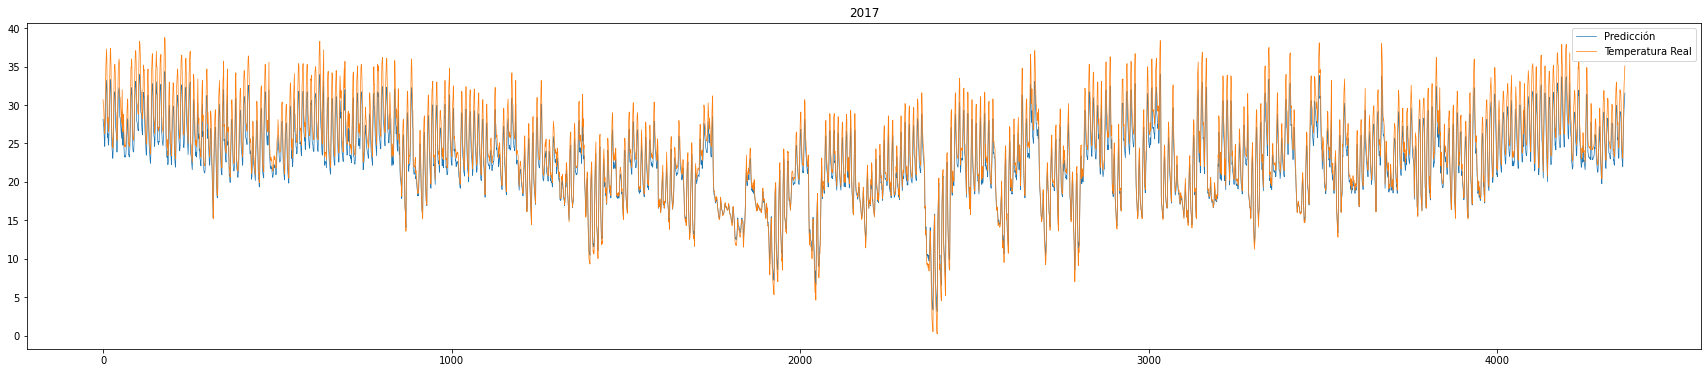

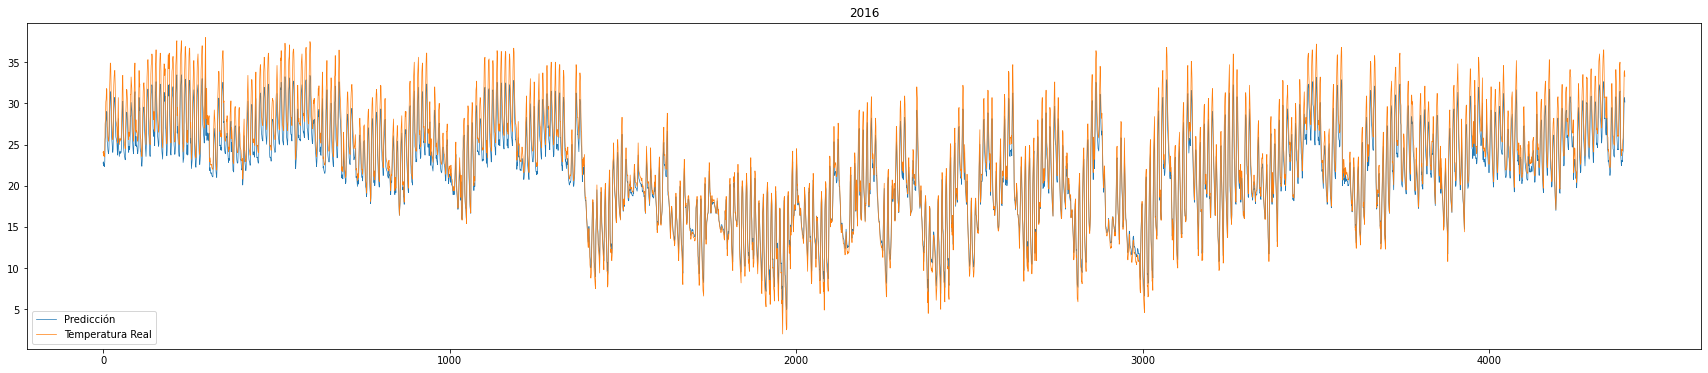

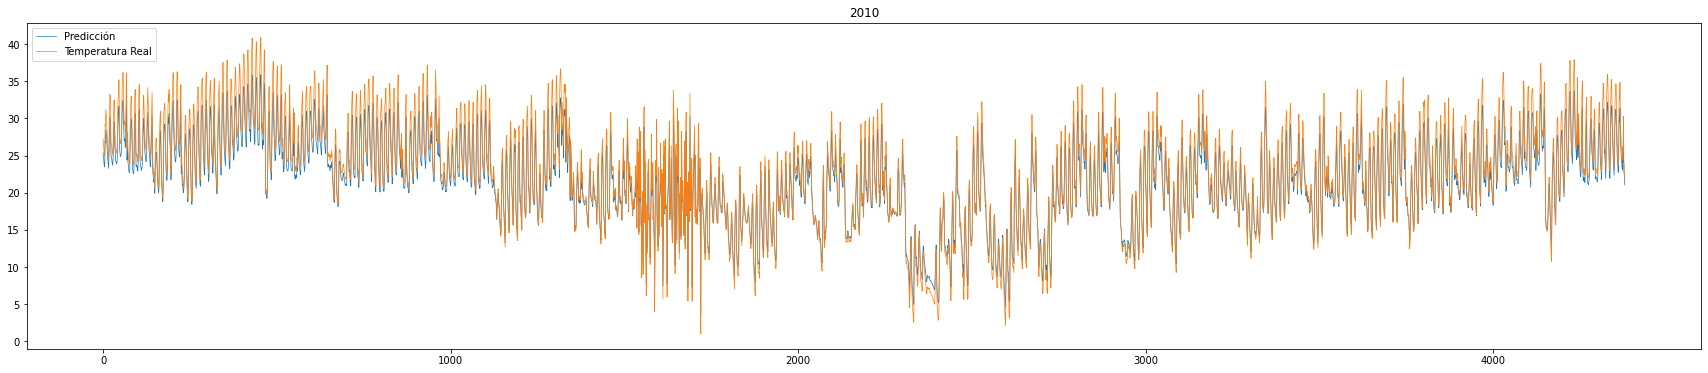

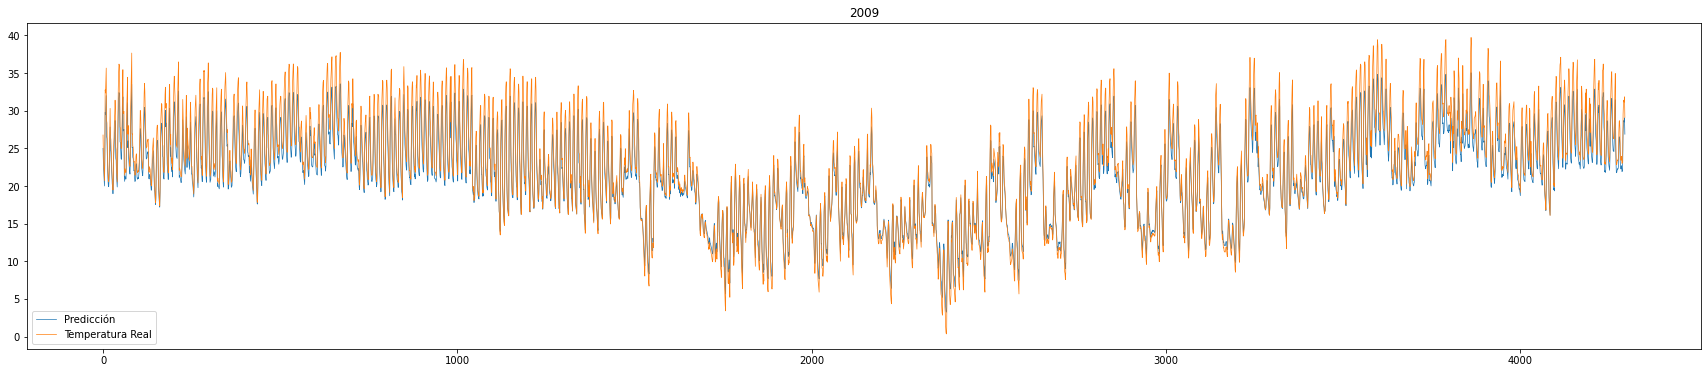

In [78]:
plt.figure(figsize= (30,6))
plt.title('2017')
plt.plot(y_pred2017, label='Predicción', linewidth=0.7)
plt.plot(Temperatura2017, label='Temperatura Real', linewidth=0.7)
plt.legend()
plt.show()
plt.figure(figsize= (30,6))
plt.title('2016')
plt.plot(y_pred2016, label='Predicción', linewidth=0.7)
plt.plot(Temperatura2016, label='Temperatura Real', linewidth=0.7)
plt.legend()
plt.show()
plt.figure(figsize= (30,6))
plt.title('2010')
plt.plot(y_pred2010, label='Predicción', linewidth=0.7)
plt.plot(Temperatura2010, label='Temperatura Real', linewidth=0.7)
plt.legend()
plt.show()
plt.figure(figsize= (30,6))
plt.title('2009')
plt.plot(y_pred2009, label='Predicción', linewidth=0.7)
plt.plot(Temperatura2009, label='Temperatura Real', linewidth=0.7)
plt.legend()
plt.show()

2009

Máxima diferencia:  [4.6856433] , Media:  -1.1038488868048784
2010

Máxima diferencia:  [4.99652863] , Media:  -1.1194637118180935
2011

Máxima diferencia:  [4.81323929] , Media:  -1.1195972066729358
2012

Máxima diferencia:  [4.8807518] , Media:  -1.3245142668637906
2013

Máxima diferencia:  [5.03540064] , Media:  -1.1728951758064252
2014

Máxima diferencia:  [5.14128342] , Media:  -1.3374293382257145
2015

Máxima diferencia:  [4.45097736] , Media:  -1.3497261932434692
2016

Máxima diferencia:  [4.23760986] , Media:  -1.154198037031669
2017

Máxima diferencia:  [4.44311218] , Media:  -1.344982662083481


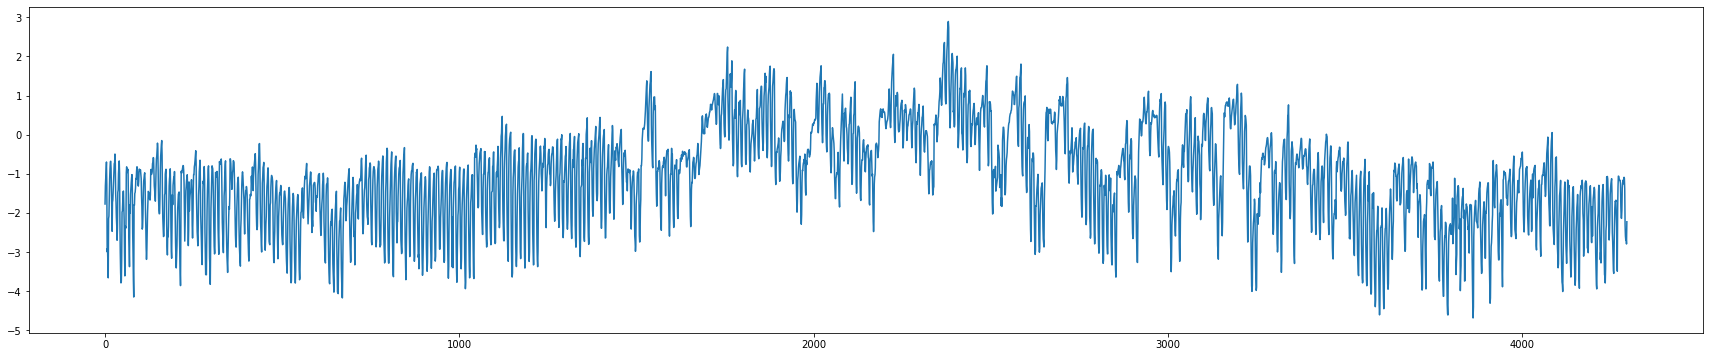

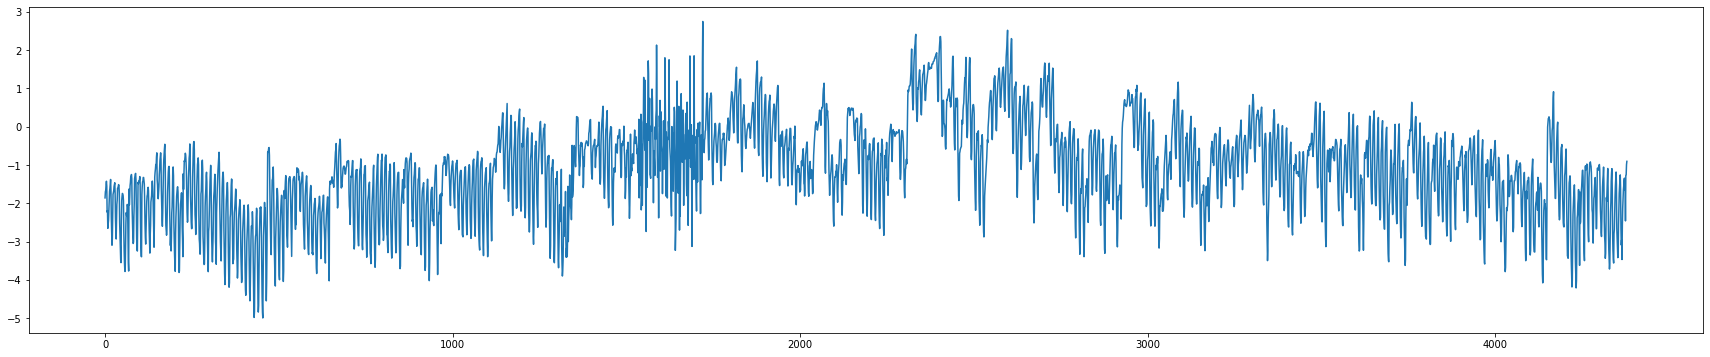

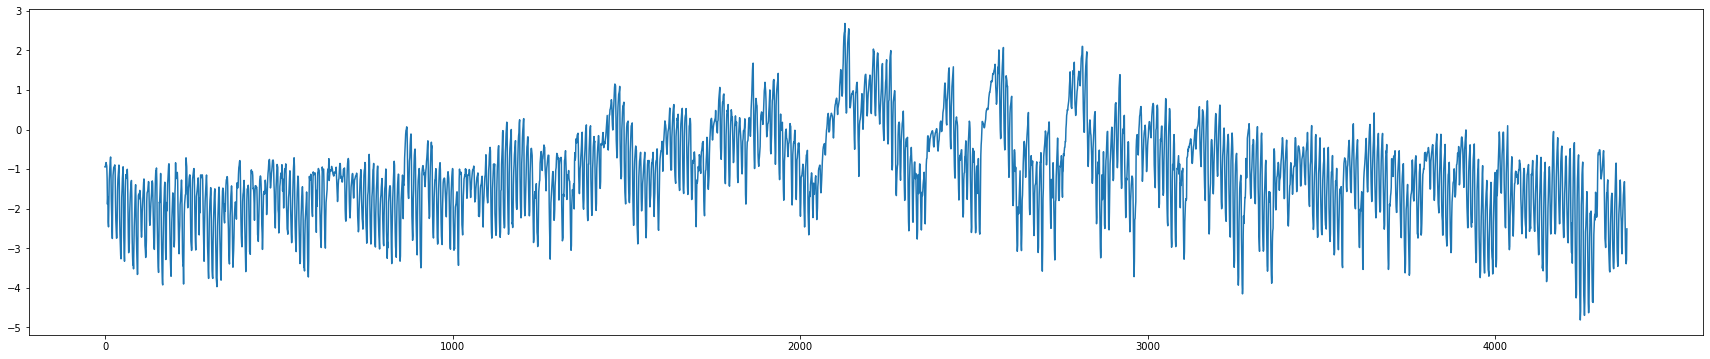

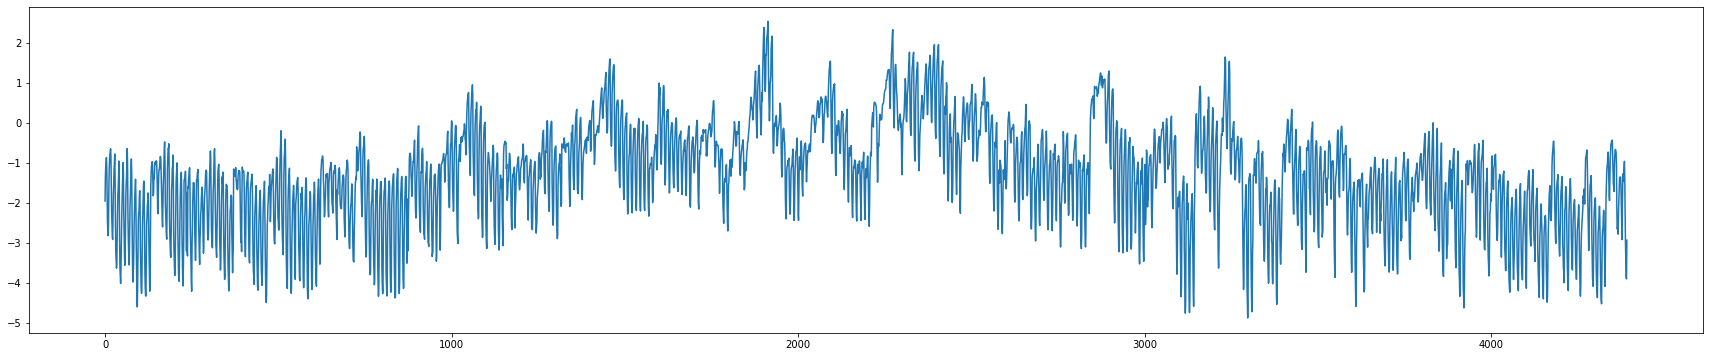

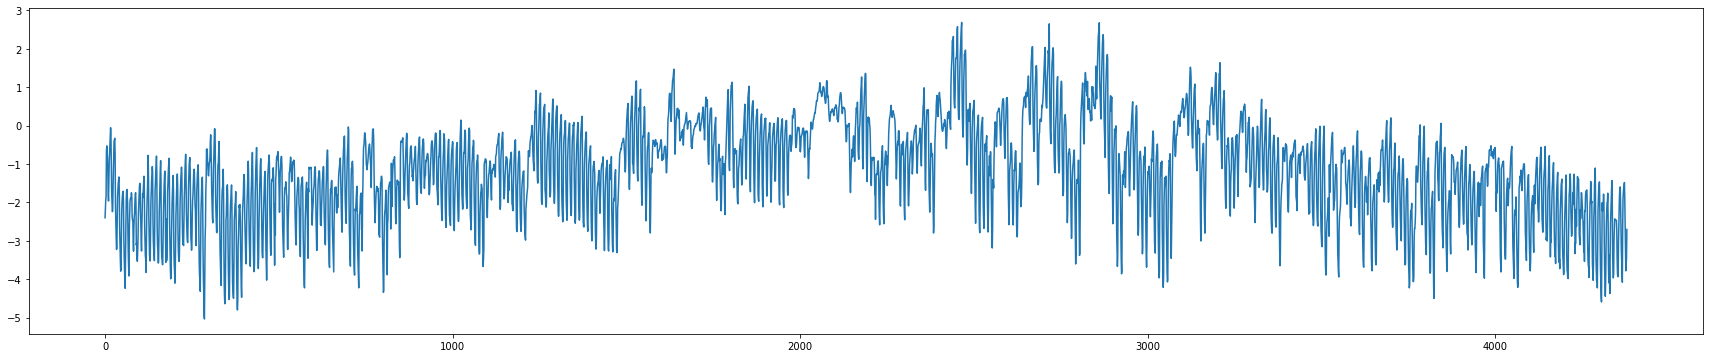

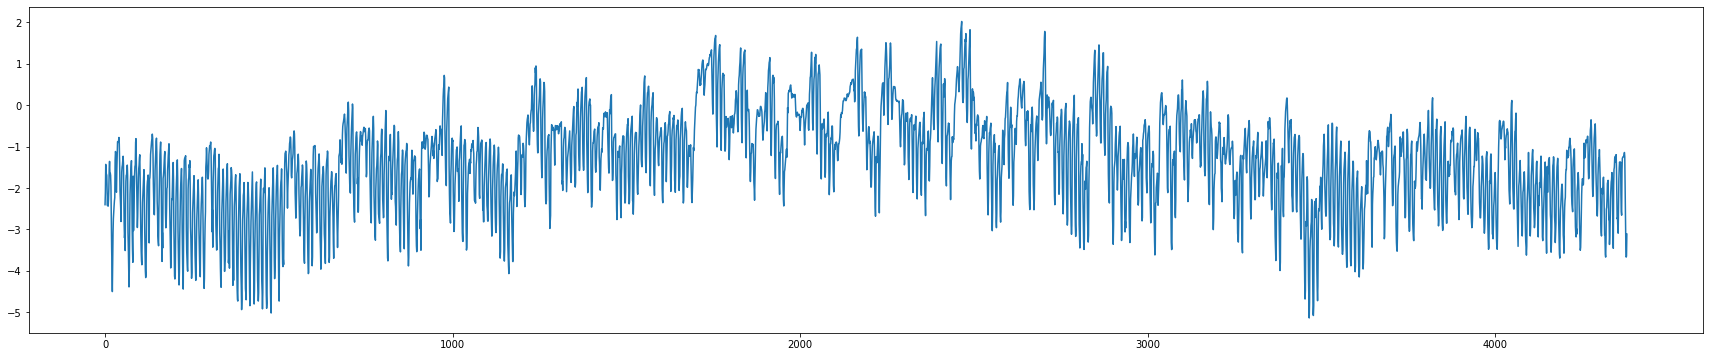

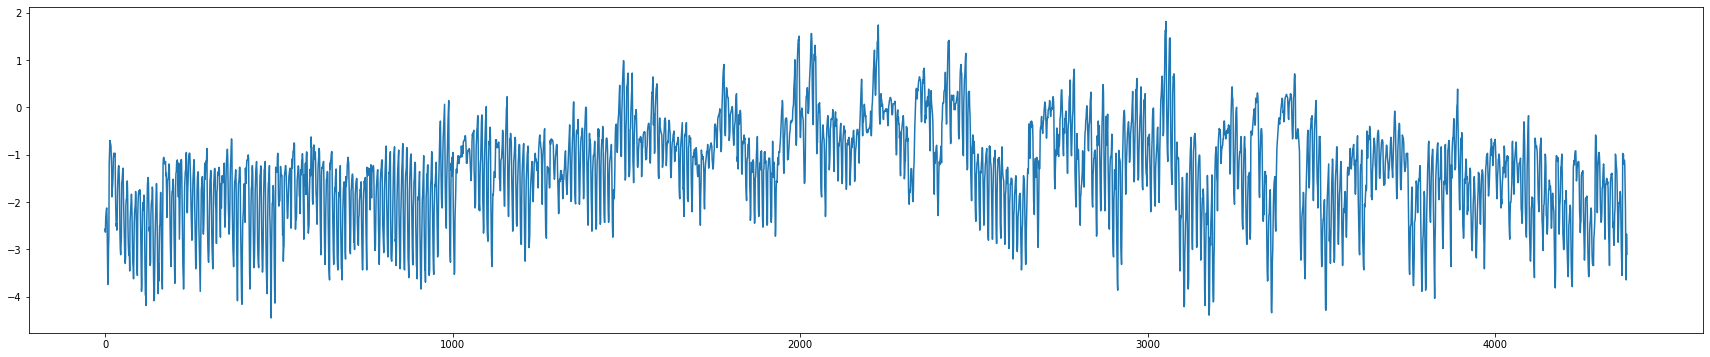

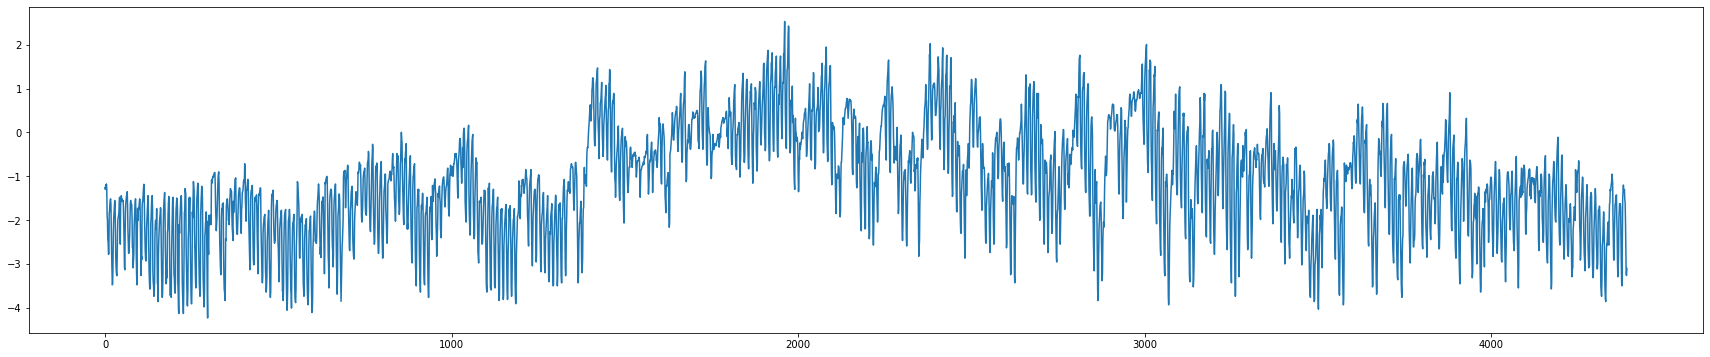

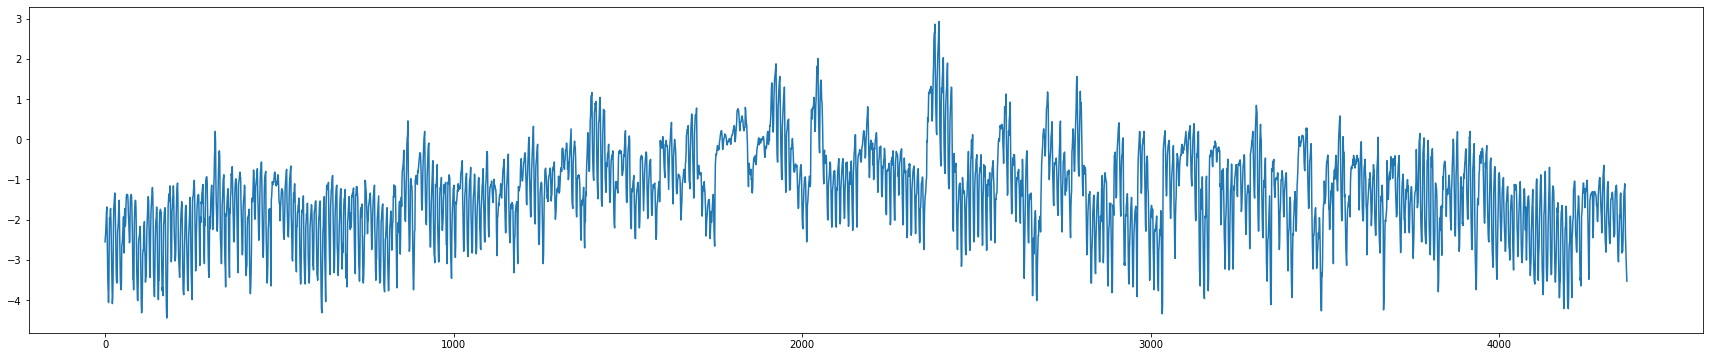

In [80]:
plt.figure(figsize= (30,6))
plt.plot(y_pred2009-Temperatura2009)
print('2009')
print('\nMáxima diferencia: ', max(np.abs(y_pred2009-np.reshape(Temperatura2009, [-1,1]))), ', Media: ', np.mean(y_pred2009-np.reshape(Temperatura2009, [-1,1])))
plt.figure(figsize= (30,6))
plt.plot(y_pred2010-Temperatura2010)
print('2010')
print('\nMáxima diferencia: ', max(np.abs(y_pred2010-np.reshape(Temperatura2010, [-1,1]))), ', Media: ', np.mean(y_pred2010-np.reshape(Temperatura2010, [-1,1])))
plt.figure(figsize= (30,6))
plt.plot(y_pred2011-Temperatura2011)
print('2011')
print('\nMáxima diferencia: ', max(np.abs(y_pred2011-np.reshape(Temperatura2011, [-1,1]))), ', Media: ', np.mean(y_pred2011-np.reshape(Temperatura2011, [-1,1])))
plt.figure(figsize= (30,6))
plt.plot(y_pred2012-Temperatura2012)
print('2012')
print('\nMáxima diferencia: ', max(np.abs(y_pred2012-np.reshape(Temperatura2012, [-1,1]))), ', Media: ', np.mean(y_pred2012-np.reshape(Temperatura2012, [-1,1])))
plt.figure(figsize= (30,6))
plt.plot(y_pred2013-Temperatura2013)
print('2013')
print('\nMáxima diferencia: ', max(np.abs(y_pred2013-np.reshape(Temperatura2013, [-1,1]))), ', Media: ', np.mean(y_pred2013-np.reshape(Temperatura2013, [-1,1])))
plt.figure(figsize= (30,6))
plt.plot(y_pred2014-Temperatura2014)
print('2014')
print('\nMáxima diferencia: ', max(np.abs(y_pred2014-np.reshape(Temperatura2014, [-1,1]))), ', Media: ', np.mean(y_pred2014-np.reshape(Temperatura2014, [-1,1])))
plt.figure(figsize= (30,6))
plt.plot(y_pred2015-Temperatura2015)
print('2015')
print('\nMáxima diferencia: ', max(np.abs(y_pred2015-np.reshape(Temperatura2015, [-1,1]))), ', Media: ', np.mean(y_pred2015-np.reshape(Temperatura2015, [-1,1])))
plt.figure(figsize= (30,6))
plt.plot(y_pred2016-Temperatura2016)
print('2016')
print('\nMáxima diferencia: ', max(np.abs(y_pred2016-np.reshape(Temperatura2016, [-1,1]))), ', Media: ', np.mean(y_pred2016-np.reshape(Temperatura2016, [-1,1])))
plt.figure(figsize= (30,6))
plt.plot(y_pred2017-Temperatura2017)
print('2017')
print('\nMáxima diferencia: ', max(np.abs(y_pred2017-np.reshape(Temperatura2017, [-1,1]))), ', Media: ', np.mean(y_pred2017-np.reshape(Temperatura2017, [-1,1])))